In [27]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from reco.matching import get_highest_energy_fraction_simtracksters
from reco.features import longest_path_from_highest_centrality, mean_edge_length, mean_edge_energy_gap


# file_name = "~/Data/pions/new_ntuples_14955802_7.root"
file_name = "~/data/multi/new_ntuples_14992862_991.root"

tracksters = uproot.open({file_name: "ticlNtuplizer/tracksters"})
simtracksters = uproot.open({file_name: "ticlNtuplizer/simtrackstersSC"})
associations = uproot.open({file_name: "ticlNtuplizer/associations"})

In [28]:
cx = tracksters["vertices_x"].array()
cy = tracksters["vertices_y"].array()
cz = tracksters["vertices_z"].array()
ce = tracksters["vertices_energy"].array()

sx = simtracksters["stsSC_vertices_x"].array()
sy = simtracksters["stsSC_vertices_y"].array()
sz = simtracksters["stsSC_vertices_z"].array()
se = simtracksters["stsSC_vertices_energy"].array()

## Number of vertices and total energy

In [29]:
nvertices = []
tenergy = []
fracs = []
t_frac = []

for e in range(len(cx)):
    te = ce[e]  # get event
    reco_fr, reco_st = get_highest_energy_fraction_simtracksters(tracksters, simtracksters, associations, e)

    for tx in range(len(te)):   
        ve = te[tx]         # get trackster
        fr = reco_fr[tx]
        nvertices.append(len(ve))
        tenergy.append(sum(ve))
        fracs.append(fr)

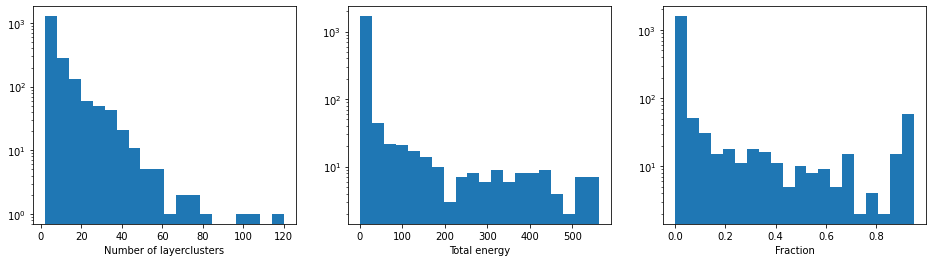

In [30]:
fig = plt.figure(figsize=(16, 4))

ax = fig.add_subplot(131)
ax.hist(nvertices, bins=20)
ax.set_yscale("log")
ax.set_xlabel("Number of layerclusters")

ax = fig.add_subplot(132)
ax.set_xlabel("Total energy")
ax.hist(tenergy, bins=20)
ax.set_yscale("log")

ax = fig.add_subplot(133)
ax.set_xlabel("Fraction")
ax.set_yscale("log")
ax.hist(fracs, bins=20)

plt.show()

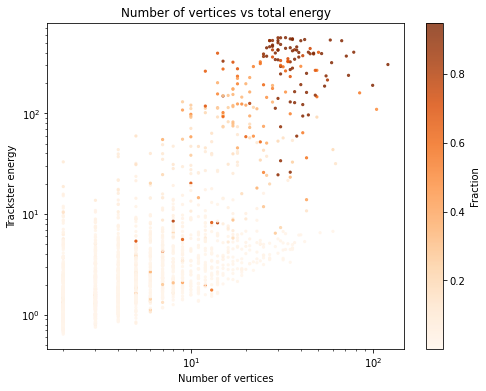

In [31]:
plt.figure(figsize=(8, 6))
plt.title("Number of vertices vs total energy")
plt.xlabel("Number of vertices")
plt.ylabel("Trackster energy")
plt.xscale("log")
plt.yscale("log")

plt.scatter(nvertices, tenergy, c=fracs, s=5, cmap="Oranges", alpha=0.8)
cbar = plt.colorbar()
cbar.set_label("Fraction")
plt.show()
# we can use the fraction as a "completeness" score

## Graph based features

In [32]:
import networkx as nx
from itertools import islice
from reco.graphs import create_graph
from reco.plotting import plot_graph_3D

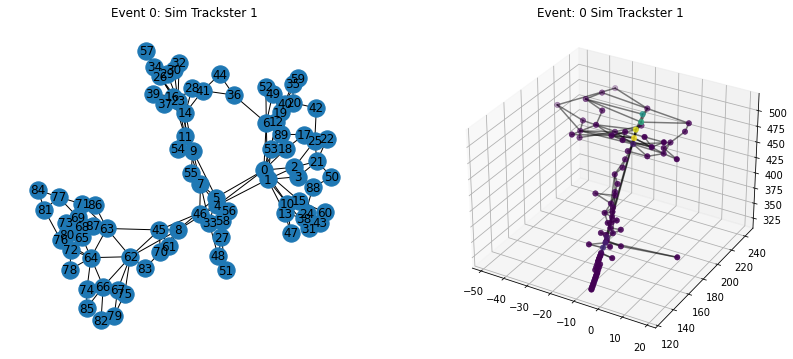

In [33]:
eid = 0
ntx = 1

simgraphs = [(create_graph(x, y, z, e, N=2), e) for x, y, z, e in zip(sx[eid], sy[eid], sz[eid], se[eid])]
G, e = simgraphs[ntx]

fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')
ax1.set_title(f"Event {eid}: Sim Trackster {ntx}")
ax2.set_title(f"Event: {eid} Sim Trackster {ntx}")

nx.draw(G, with_labels=True, ax=ax1)
plot_graph_3D(G, e, ax=ax2)

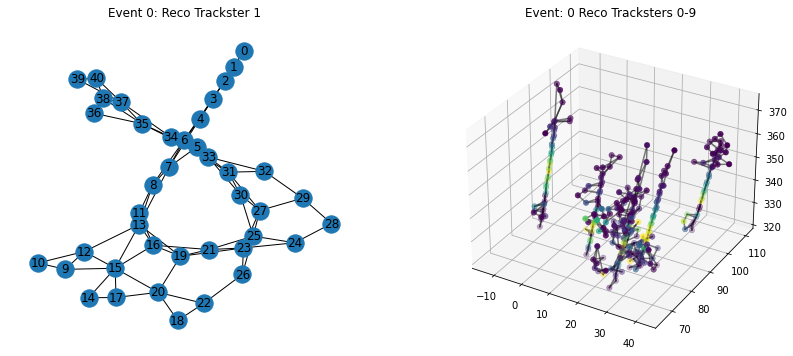

In [34]:
num_graphs = 10

graphs = [(create_graph(x, y, z, e, N=2), e) for x, y, z, e in zip(cx[eid], cy[eid], cz[eid], ce[eid])]

fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')
ax1.set_title(f"Event {eid}: Reco Trackster {ntx}")
ax2.set_title(f"Event: {eid} Reco Tracksters 0-{num_graphs-1}")
nx.draw(graphs[ntx][0], with_labels=True, ax=ax1)
for G, e in graphs[:num_graphs]:
    plot_graph_3D(G, e, ax=ax2)

### Centrality and longest path

Construct graphs by connecting to the nearest-higher.
- Using N=1 (number of nearest highers) to highlight the difference in distances.

In [35]:
centr = []

for eid in range(len(cx)):
    _graphs = [create_graph(x, y, z, e, N=1) for x, y, z, e in zip(cx[eid], cy[eid], cz[eid], ce[eid])]
    for G in _graphs:
        centr.append(longest_path_from_highest_centrality(G))

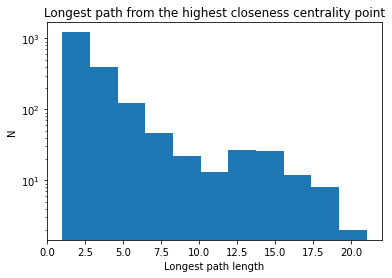

In [36]:
plt.figure(figsize=(6, 4))
plt.title("Longest path from the highest closeness centrality point")
plt.ylabel("N")
plt.yscale("log")
plt.xlabel("Longest path length")
plt.hist(centr, bins=11)
plt.show()

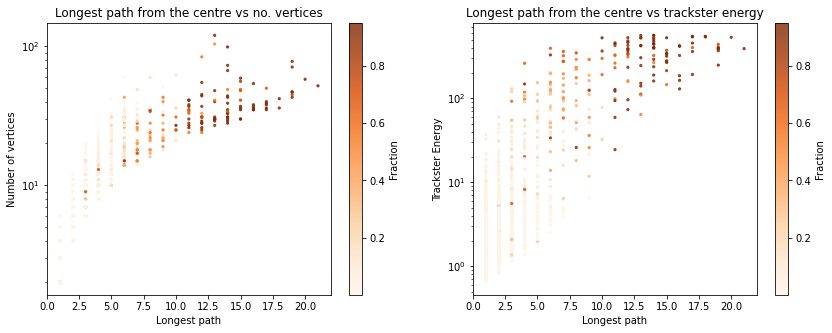

In [42]:
fig = plt.figure(figsize=(14, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.set_title("Longest path from the centre vs no. vertices")
ax1.set_xlabel("Longest path")
ax1.set_ylabel("Number of vertices")
ax1.set_yscale("log")

sc1 = ax1.scatter(centr, nvertices, c=fracs, s=5, cmap="Oranges", alpha=0.8)
cbar1 = fig.colorbar(sc1, ax=ax1)
cbar1.set_label("Fraction")

ax2.set_title("Longest path from the centre vs trackster energy")
ax2.set_xlabel("Longest path")
ax2.set_ylabel("Trackster Energy")
ax2.set_yscale("log")

sc2 = ax2.scatter(centr, tenergy, c=fracs, s=5, cmap="Oranges", alpha=0.8)
cbar2 = fig.colorbar(sc2, ax=ax2)
cbar2.set_label("Fraction")

plt.show()

### Node based features
- Average difference in energy
    - difference in energy between neighbours
    - assumes well formed tracksters are smoother

- average distance between nodes
    - same but using distance

In [18]:
avg_ediff = []
avg_ndist = []

for eid in range(len(cx)):
    _graphs = [create_graph(x, y, z, e, N=1) for x, y, z, e in zip(cx[eid], cy[eid], cz[eid], ce[eid])]
    for G in _graphs:
        avg_ndist.append(mean_edge_length(G))
        avg_ediff.append(mean_edge_energy_gap(G))


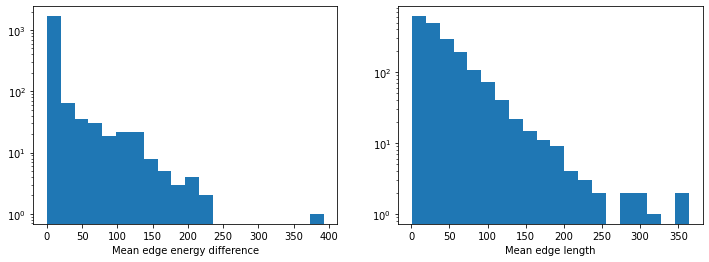

In [19]:
fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(121)
ax1.hist(avg_ediff, bins=20)
ax1.set_yscale("log")
ax1.set_xlabel("Mean edge energy difference")

ax2 = fig.add_subplot(122)
ax2.set_xlabel("Mean edge length")
ax2.hist(avg_ndist, bins=20)
ax2.set_yscale("log")

plt.show()

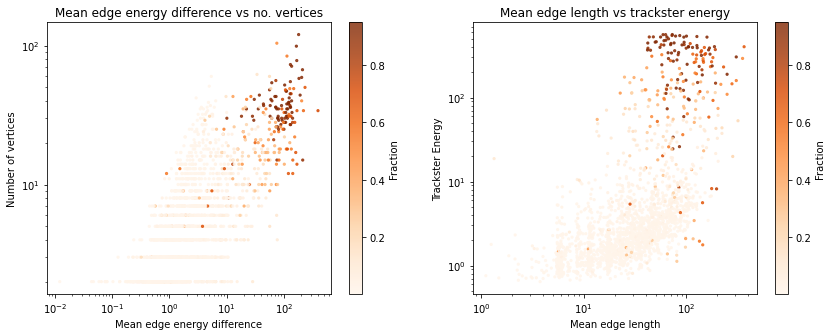

In [20]:
fig = plt.figure(figsize=(14, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.set_title("Mean edge energy difference vs no. vertices")
ax1.set_xlabel("Mean edge energy difference")
ax1.set_ylabel("Number of vertices")
ax1.set_xscale("log")
ax1.set_yscale("log")

sc1 = ax1.scatter(avg_ediff, nvertices, c=fracs, s=5, cmap="Oranges", alpha=0.8)
cbar1 = fig.colorbar(sc1, ax=ax1)
cbar1.set_label("Fraction")

ax2.set_title("Mean edge length vs trackster energy")
ax2.set_xlabel("Mean edge length")
ax2.set_ylabel("Trackster Energy")
ax2.set_xscale("log")
ax2.set_yscale("log")

sc2 = ax2.scatter(avg_ndist, tenergy, c=fracs, s=5, cmap="Oranges", alpha=0.8)
cbar2 = fig.colorbar(sc2, ax=ax2)
cbar2.set_label("Fraction")

plt.show()

## Combine the features with PCA

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()

X = np.array((nvertices, tenergy, centr, avg_ediff, avg_ndist)).T
Xs = scaler.fit_transform(X)

pca = PCA(n_components=2).fit(Xs)
data = pca.transform(Xs)

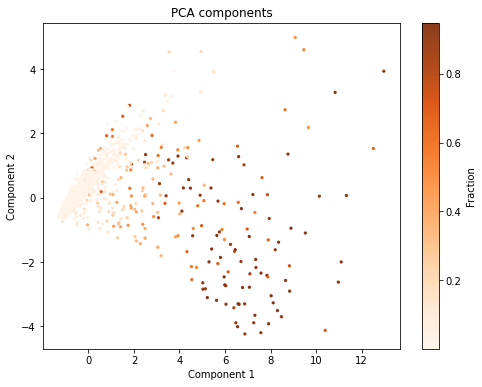

In [26]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)

ax1.set_title("PCA components")
ax1.set_xlabel("Component 1")
ax1.set_ylabel("Component 2")

sc1 = ax1.scatter(data[:,0], data[:,1], c=fracs, s=5, cmap="Oranges", alpha=0.9)
cbar1 = fig.colorbar(sc1, ax=ax1)
cbar1.set_label("Fraction")

plt.show()